In [1]:
import os

import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.optimize import minimize
from scipy.stats import norm
import math
import matplotlib.pyplot as plt
from scipy import stats
import scipy.special as sc
from scipy.special import beta

In [10]:
filename = 'C:/Users/User/OneDrive/Desktop/github-repo-folder/adv_bus_analytics/homework_2/retention_data_geometricmodel-1 (1).xlsx'
data_in = pd.read_excel(filename, usecols='A:D')

In [11]:
data_in = data_in.rename(columns={'# Customers':'Customers', '% Alive':'Alive', 'retention rate':'retention'})

In [12]:
data_in

,Year,Customers,Alive,retention
0,0,1000,1.000,NaN
1,1,631,0.631,0.631000
2,2,468,0.468,0.741680
3,3,382,0.382,0.816239
4,4,326,0.326,0.853403
5,5,289,0.289,0.886503
6,6,262,0.262,0.906574
7,7,241,0.241,0.919847
8,8,223,0.223,0.925311
9,9,207,0.207,0.928251


This is *aggregated* data. It lists the total number of people retained at each time point. If it listed every person separately, it would be *individual* data.

Let's consider the first 8 years, because that's what will be used to train the model. Plot the retention rate.

Text(0, 0.5, 'Retention Rate')

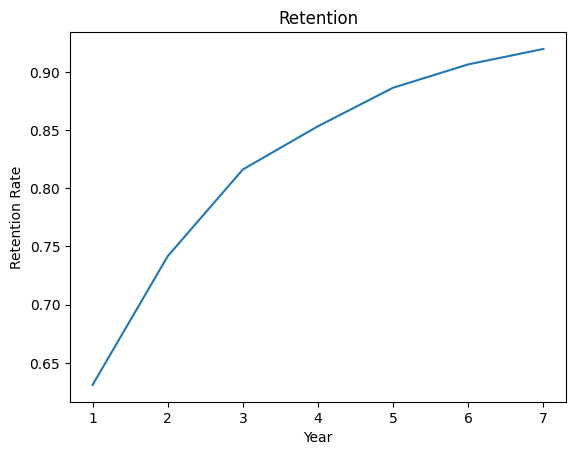

In [5]:
plt.plot(data_in[0:8].Year, data_in[0:8].retention)
plt.title('Retention')
plt.xlabel('Year')
plt.ylabel('Retention Rate')

and the number of customers per year

Text(0, 0.5, 'Customers')

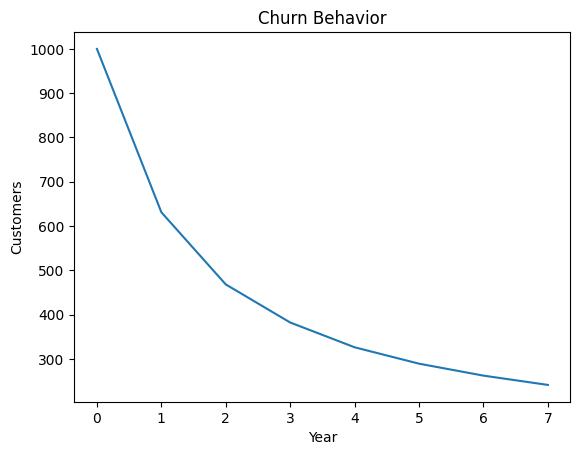

In [6]:
plt.plot(data_in[0:8].Year, data_in[0:8].Customers)
plt.title('Churn Behavior')
plt.xlabel('Year')
plt.ylabel('Customers')

Now create a column with how many people churn every year. The 1 in the first row is just filler.

In [7]:
data_in['lost'] = 1
for i in range(0,12):
    data_in.loc[i+1, 'lost'] = data_in.Customers[i] - data_in.Customers[i+1]

In [8]:
data_in

,Year,Customers,Alive,retention,lost
0,0,1000,1.000,NaN,1
1,1,631,0.631,0.631000,369
2,2,468,0.468,0.741680,163
3,3,382,0.382,0.816239,86
4,4,326,0.326,0.853403,56
5,5,289,0.289,0.886503,37
6,6,262,0.262,0.906574,27
7,7,241,0.241,0.919847,21
8,8,223,0.223,0.925311,18
9,9,207,0.207,0.928251,16


Train a model using the first 8 years. Then make predictions for the remaining years in the dataset.

## Exponential Models

We use an exponential distribution rather than the discrete geometric that we used before. 

We make the approximation f(t) = F(t) - F(t-1).

#### One Segment

In [9]:
# we take the first 8 rows
data = data_in.copy()
data = data[0:8]

In [10]:
data

,Year,Customers,Alive,retention,lost
0,0,1000,1.000,NaN,1
1,1,631,0.631,0.631000,369
2,2,468,0.468,0.741680,163
3,3,382,0.382,0.816239,86
4,4,326,0.326,0.853403,56
5,5,289,0.289,0.886503,37
6,6,262,0.262,0.906574,27
7,7,241,0.241,0.919847,21


In [11]:
def MLE_Exp(params):

    lamda = params

    F_t = 1 - np.exp(-lamda * data.Year)
    F_t_minus_1 =  1 - np.exp(-lamda * (data.Year - 1))
    prob_churn = F_t - F_t_minus_1

    # Be careful - the value for year 0 is not realistic. It is calculated with a year -1,
    # which doesn't appear in the dataset. Therefore, when finding the sum of log likelihoods,
    # only use years 1 to 7.
    log_like = np.sum(np.log(prob_churn[1:]) * data.lost[1:])

    # Now we've found the sum of log likelihoods for all the people who churned.
    # But what about the people who haven't churned? Add that in now.
    prob_not_churn = 1 - F_t[7]
    log_like = log_like + np.log(prob_not_churn) * data.Customers[7]

    return -log_like

In [12]:
x0 = [0.1]
bounds = [(0, 100)]
mle_exp = minimize(MLE_Exp, x0 = x0, method='Nelder-mead', bounds=bounds, options={'disp': True})
mle_exp

Optimization terminated successfully.
         Current function value: 1794.620861
         Iterations: 15
         Function evaluations: 30


 final_simplex: (array([[0.25625   ],
       [0.25617188]]), array([1794.62086131, 1794.62086837]))
           fun: 1794.6208613052322
       message: 'Optimization terminated successfully.'
          nfev: 30
           nit: 15
        status: 0
       success: True
             x: array([0.25625])

This estimate is very close to what we get with the geometric model. Now do prediction on all time points up to t=12.

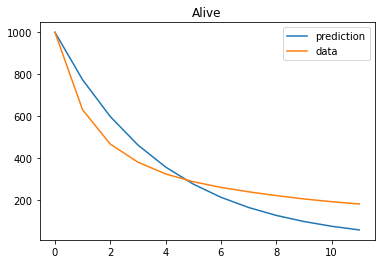

In [13]:
# Note that we use data_in because we want to study all 12 years.

lamda = mle_exp.x[0]
pop_size = data_in.Customers[0] # 1000 customers

# Estimate how many churns at time t by taking (CDF(t+1) - CDF(t)) * N
churn = ((1 - np.exp(-lamda * data_in.Year)) - (1 - np.exp(-lamda * (data_in.Year - 1)))) * pop_size

pred_alive = [None] * 12
pred_alive[0] = pop_size
for i in range(1, 12):
    pred_alive[i] = pred_alive[i-1] - churn[i]

plt.plot(pred_alive, label='prediction')
plt.plot(data_in.Customers[0:12], label='data')
plt.legend()
plt.title('Alive')
plt.show()

It is as expected - a decent fit to the data with very parsimonious data.

Plot hazard rate. Use the formula for hazard just to show that it can be done.

In [9]:
c = 1
haz = c*lamda*data_in.Year**(c-1)

emp_haz = [None]*13
for t in range(1, 13):
    emp_haz[t] = data_in.lost[t]/data_in.Customers[t-1]

plt.plot(haz, label='exponential')
plt.plot(emp_haz, label='empirical')
plt.title('hazard')
plt.legend()
plt.show()

print(data_in)

NameError: name 'lamda' is not defined

It's a constant hazard model, as expected.

In [15]:
num_params = 1
BIC = num_params * np.log(pop_size) - 2 * (-mle_exp.fun) 
BIC

3596.1494778894466

#### Two Discrete Segments

We can estimate two segments. Remember that continuous distribution to discrete data introduces errors since we are trying to disaggregate discrete data.

So, to get the two segments, we calculate the probability of churn by F(t)-F(t-1) and the probability of belonging to segment 1, called p. So below we calculate for segment 1 and segment 2. Again, recall we have few data points which are discrete and we are fitting a continuous distribution.

In [23]:
# we take the first 8 rows
data = data_in.copy()
data = data[0:8]

def MLE_Exp2Seg(params):

    lamda1 = params[0]
    lamda2 = params[1]
    p = params[2]

    # Find the probability of churning if the customer is from group 1 and if they
    # are from group 2.
    Prob1 = (1 - np.exp(-lamda1 * data.Year)) - (1 - np.exp(-lamda1 * (data.Year - 1)))
    Prob2 = (1 - np.exp(-lamda2 * data.Year)) - (1 - np.exp(-lamda2 * (data.Year - 1)))

    # Use the law of total probability.
    Prob = p * Prob1 + (1-p) * Prob2

    # Now find the probability of not churning. It is one minus the sum of all
    # the prior probabilities of churning.
    Prob_not_churn_1 = 1 - np.sum(Prob1[1:])
    Prob_not_churn_2 = 1 - np.sum(Prob2[1:])
    
    # Use the law of total probability.
    Prob_not_churn = p * Prob_not_churn_1 + (1-p) * Prob_not_churn_2

    # Find the sum of log-likelihoods. Be sure to weight by the number of customers
    # churning at each time point. Remember that time t=0 doesn't have a realistic
    # value and should be ignored.
    LL = np.sum(np.log(Prob[1:]) * data_in.lost[1:])

    # Add in the log-likelihood for the people who hadn't churned by year 7.
    LL += np.log(Prob_not_churn) * data_in.Customers[7]

    return -LL

In [24]:
bounds = [(0, 100), (0, 100), (0.001, 0.99)]
x0 = [0.2, 0.4, 0.5]
mle_model = minimize(MLE_Exp2Seg, x0 = x0, method='Nelder-mead', bounds=bounds, options={'disp': True})
mle_model

Optimization terminated successfully.
         Current function value: 1680.045548
         Iterations: 84
         Function evaluations: 149


 final_simplex: (array([[0.08668166, 0.88193256, 0.43938035],
       [0.08666415, 0.88185462, 0.43934607],
       [0.08666546, 0.8818423 , 0.43932442],
       [0.08667712, 0.88186565, 0.4393678 ]]), array([1680.04554816, 1680.04554843, 1680.04554843, 1680.0455486 ]))
           fun: 1680.0455481565066
       message: 'Optimization terminated successfully.'
          nfev: 149
           nit: 84
        status: 0
       success: True
             x: array([0.08668166, 0.88193256, 0.43938035])

The estimate look reasonable except churn probability 0.88 looks high. But recall in the exponential model the estimate does not make a huge different to churn. Earlier we have 0.58, but the probability of churning in first few periods remain very high (90% or more) in both estimates.

This is the potential limitation to applying continuous to discrete data when number of observations are small.

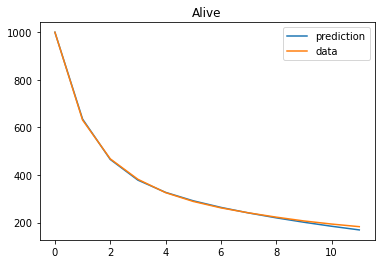

In [25]:
# Note that we use data_in because we want to study all 12 years.

lamda1, lamda2, p = mle_model.x
pop_size = data_in.Customers[0] # 1000 customers

# Estimate how many churns at time t by taking (CDF(t+1) - CDF(t)) * N
Prob1 = (1 - np.exp(-lamda1 * data_in.Year)) - (1 - np.exp(-lamda1 * (data_in.Year - 1)))
Prob2 = (1 - np.exp(-lamda2 * data_in.Year)) - (1 - np.exp(-lamda2 * (data_in.Year - 1)))

# Use the law of total probability.
Prob = p * Prob1 + (1-p) * Prob2

churn = Prob * pop_size

pred_alive = [None] * 12
pred_alive[0] = pop_size
for i in range(1, 12):
    pred_alive[i] = pred_alive[i-1] - churn[i]

plt.plot(pred_alive, label='prediction')
plt.plot(data_in.Customers[0:12], label='data')
plt.legend()
plt.title('Alive')
plt.show()

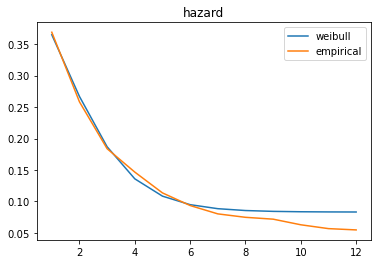

In [26]:
pred_haz = [None]*13
for t in range(1, 13):
    pred_haz[t] = churn[t]/pred_alive[t-1]

emp_haz = [None]*13
for t in range(1, 13):
    emp_haz[t] = data_in.lost[t]/data_in.Customers[t-1]

plt.plot(pred_haz, label='weibull')
plt.plot(emp_haz, label='empirical')
plt.title('hazard')
plt.legend()
plt.show()

In [27]:
num_params = 3
BIC = num_params * np.log(pop_size) - 2 * (-mle_model.fun) 
BIC

3380.8143621499594

#### Infinite Segments - Exponential Gamma Model

In [33]:
# we take the first 8 rows
data = data_in.copy()
data = data[0:8]

def MLE_Exp_Gamma(params):

    alpha = params[0]
    r = params[1]

    # Find the probability of churning.
    F_t = 1 - (alpha/(alpha + data.Year))**r
    F_t_minus_1 = 1 - (alpha/(alpha + (data.Year - 1)))**r
    Prob = F_t - F_t_minus_1

    # Now find the probability of not churning. It is one minus the sum of all
    # the prior probabilities of churning.
    Prob_not_churn = 1 - np.sum(Prob[1:])

    # Find the sum of log-likelihoods. Be sure to weight by the number of customers
    # churning at each time point. Remember that time t=0 doesn't have a realistic
    # value and should be ignored.
    LL = np.sum(np.log(Prob[1:]) * data_in.lost[1:])

    # Add in the log-likelihood for the people who hadn't churned by year 7.
    LL += np.log(Prob_not_churn) * data_in.Customers[7]

    return -LL

$\alpha$ and $r$ must be greater than 0 but are otherwise unbounded.

In [34]:
bounds = [(0, 100), (0, 100)]
x0 = [1, 1]
mle_model = minimize(MLE_Exp_Gamma, x0 = x0, method='Nelder-mead', bounds=bounds, options={'disp': True})
mle_model

Optimization terminated successfully.
         Current function value: 1680.296740
         Iterations: 38
         Function evaluations: 74


 final_simplex: (array([[1.07276998, 0.70942845],
       [1.07268241, 0.70938772],
       [1.07277696, 0.70940447]]), array([1680.29674025, 1680.29674027, 1680.29674028]))
           fun: 1680.296740254128
       message: 'Optimization terminated successfully.'
          nfev: 74
           nit: 38
        status: 0
       success: True
             x: array([1.07276998, 0.70942845])

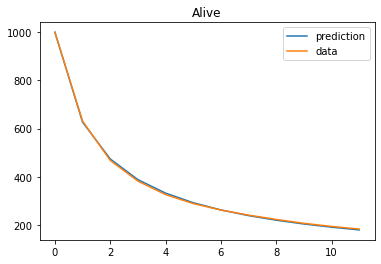

In [35]:
# Note that we use data_in because we want to study all 12 years.
pop_size = data_in.Customers[0] # 1000 customers

alpha = mle_model.x[0]
r = mle_model.x[1]

# Find the probability of churning.
F_t = 1 - (alpha/(alpha + data_in.Year))**r
F_t_minus_1 = 1 - (alpha/(alpha + (data_in.Year - 1)))**r
Prob = F_t - F_t_minus_1

churn = Prob * pop_size

pred_alive = [None] * 12
pred_alive[0] = pop_size
for i in range(1, 12):
    pred_alive[i] = pred_alive[i-1] - churn[i]

plt.plot(pred_alive, label='prediction')
plt.plot(data_in.Customers[0:12], label='data')
plt.legend()
plt.title('Alive')
plt.show()

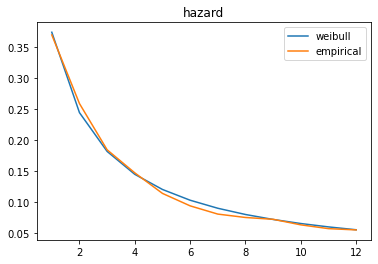

In [36]:
pred_haz = [None]*13
for t in range(1, 13):
    pred_haz[t] = churn[t]/pred_alive[t-1]

emp_haz = [None]*13
for t in range(1, 13):
    emp_haz[t] = data_in.lost[t]/data_in.Customers[t-1]

plt.plot(pred_haz, label='weibull')
plt.plot(emp_haz, label='empirical')
plt.title('hazard')
plt.legend()
plt.show()

In [37]:
num_params = 2
BIC = num_params * np.log(pop_size) - 2 * (-mle_model.fun) 
BIC

3374.4089910662206

## Weibull models

Now use the Weibull family of distributions.

#### One Segment

In [16]:
# we take the first 8 rows
data = data_in.copy()
data = data[0:8]

In [17]:
data

,Year,Customers,Alive,retention,lost
0,0,1000,1.000,NaN,1
1,1,631,0.631,0.631000,369
2,2,468,0.468,0.741680,163
3,3,382,0.382,0.816239,86
4,4,326,0.326,0.853403,56
5,5,289,0.289,0.886503,37
6,6,262,0.262,0.906574,27
7,7,241,0.241,0.919847,21


In [18]:
def MLE_Weib(params):

    lamda, c = params

    F_t = 1 - np.exp(-lamda * data.Year**c)
    F_t_minus_1 =  1 - np.exp(-lamda * (data.Year - 1)**c)
    prob_churn = F_t - F_t_minus_1

    # Be careful - the value for year 0 is not realistic. It is calculated with a year -1,
    # which doesn't appear in the dataset. Therefore, when finding the sum of log likelihoods,
    # only use years 1 to 7.
    log_like = np.sum(np.log(prob_churn[1:]) * data.lost[1:])

    # Now we've found the sum of log likelihoods for all the people who churned.
    # But what about the people who haven't churned? Add that in now.
    prob_not_churn = 1 - F_t[7]
    log_like = log_like + np.log(prob_not_churn) * data.Customers[7]

    return -log_like

In [19]:
x0 = [1, 1]
bounds = [(0, 100), (0, 100)]
mle_weib = minimize(MLE_Weib, x0 = x0, method='Nelder-mead', bounds=bounds, options={'disp': True})
mle_weib

Optimization terminated successfully.
         Current function value: 1688.520242
         Iterations: 40
         Function evaluations: 76


C:\Users\rston\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 final_simplex: (array([[0.47992934, 0.57160843],
       [0.479972  , 0.57152658],
       [0.48001037, 0.57156474]]), array([1688.52024179, 1688.52024188, 1688.52024731]))
           fun: 1688.5202417884097
       message: 'Optimization terminated successfully.'
          nfev: 76
           nit: 40
        status: 0
       success: True
             x: array([0.47992934, 0.57160843])

Now do prediction on all time points up to t=12.

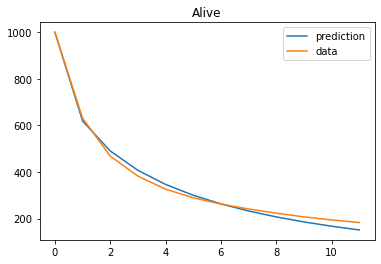

In [20]:
# Note that we use data_in because we want to study all 12 years.

lamda, c = mle_weib.x
pop_size = data_in.Customers[0] # 1000 customers

# Estimate how many churns at time t by taking (CDF(t+1) - CDF(t)) * N
churn = ((1 - np.exp(-lamda * data_in.Year**c)) - (1 - np.exp(-lamda * (data_in.Year - 1)**c))) * pop_size

pred_alive = [None] * 12
pred_alive[0] = pop_size
for i in range(1, 12):
    pred_alive[i] = pred_alive[i-1] - churn[i]

plt.plot(pred_alive, label='prediction')
plt.plot(data_in.Customers[0:12], label='data')
plt.legend()
plt.title('Alive')
plt.show()

Plot the hazard. Use the equation for hazard just to show that it can be done.

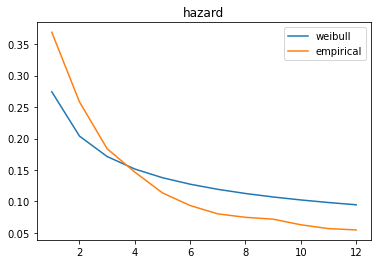

In [21]:
haz = c*lamda*data_in.Year**(c-1)

emp_haz = [None]*13
for t in range(1, 13):
    emp_haz[t] = data_in.lost[t]/data_in.Customers[t-1]

plt.plot(haz, label='weibull')
plt.plot(emp_haz, label='empirical')
plt.title('hazard')
plt.legend()
plt.show()

In [22]:
num_params = 2
BIC = num_params * np.log(pop_size) - 2 * (-mle_exp.fun) 
BIC

3603.057233168429

This is a bit better than the 1-segment exponential model.

#### Two Discrete Segments

In [28]:
# we take the first 8 rows
data = data_in.copy()
data = data[0:8]

def MLE_Weib2Seg(params):

    lamda1 = params[0]
    c1 = params[1]
    lamda2 = params[2]
    c2 = params[3]
    p = params[4]

    # Find the probability of churning if the customer is from group 1 and if they
    # are from group 2.
    Prob1 = (1 - np.exp(-lamda1 * data.Year**c1)) - (1 - np.exp(-lamda1 * (data.Year - 1)**c1))
    Prob2 = (1 - np.exp(-lamda2 * data.Year**c2)) - (1 - np.exp(-lamda2 * (data.Year - 1)**c2))

    # Use the law of total probability.
    Prob = p * Prob1 + (1-p) * Prob2

    # Now find the probability of not churning. It is one minus the sum of all
    # the prior probabilities of churning.
    Prob_not_churn_1 = 1 - np.sum(Prob1[1:])
    Prob_not_churn_2 = 1 - np.sum(Prob2[1:])
    
    # Use the law of total probability.
    Prob_not_churn = p * Prob_not_churn_1 + (1-p) * Prob_not_churn_2

    # Find the sum of log-likelihoods. Be sure to weight by the number of customers
    # churning at each time point. Remember that time t=0 doesn't have a realistic
    # value and should be ignored.
    LL = np.sum(np.log(Prob[1:]) * data_in.lost[1:])

    # Add in the log-likelihood for the people who hadn't churned by year 7.
    LL += np.log(Prob_not_churn) * data_in.Customers[7]

    return -LL

In [29]:
bounds = [(0, 100), (0, 100), (0, 100), (0, 100), (0.001, 0.99)]
x0 = [0.5, 0.5, 1, 1, 0.5]
mle_model = minimize(MLE_Weib2Seg, x0 = x0, method='Nelder-mead', bounds=bounds, options={'disp': True})
mle_model

Optimization terminated successfully.
         Current function value: 1679.608029
         Iterations: 434
         Function evaluations: 690


 final_simplex: (array([[0.1388536 , 0.77056961, 0.81412573, 0.9013621 , 0.43939368],
       [0.13888559, 0.77050695, 0.8141321 , 0.90137171, 0.43942394],
       [0.13887685, 0.77052155, 0.81412688, 0.90136685, 0.43941438],
       [0.13888783, 0.77050467, 0.8141325 , 0.9013738 , 0.43942753],
       [0.13883945, 0.77060059, 0.81412893, 0.90135436, 0.4393805 ],
       [0.13887417, 0.77053519, 0.81413616, 0.90137031, 0.43941714]]), array([1679.60802949, 1679.60802949, 1679.60802949, 1679.60802949,
       1679.60802949, 1679.60802949]))
           fun: 1679.6080294925596
       message: 'Optimization terminated successfully.'
          nfev: 690
           nit: 434
        status: 0
       success: True
             x: array([0.1388536 , 0.77056961, 0.81412573, 0.9013621 , 0.43939368])

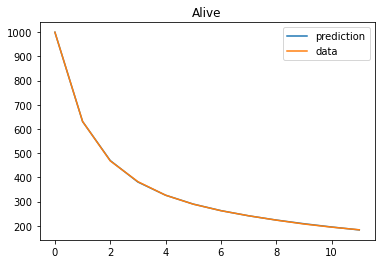

In [30]:
# Note that we use data_in because we want to study all 12 years.

lamda1 = mle_model.x[0]
c1 = mle_model.x[1]
lamda2 = mle_model.x[2]
c2 = mle_model.x[3]
p = mle_model.x[4]

pop_size = data_in.Customers[0] # 1000 customers

# Find the probability of churning if the customer is from group 1 and if they
# are from group 2.
Prob1 = (1 - np.exp(-lamda1 * data_in.Year**c1)) - (1 - np.exp(-lamda1 * (data_in.Year - 1)**c1))
Prob2 = (1 - np.exp(-lamda2 * data_in.Year**c2)) - (1 - np.exp(-lamda2 * (data_in.Year - 1)**c2))

# Use the law of total probability.
Prob = p * Prob1 + (1-p) * Prob2

churn = Prob * pop_size

pred_alive = [None] * 12
pred_alive[0] = pop_size
for i in range(1, 12):
    pred_alive[i] = pred_alive[i-1] - churn[i]

plt.plot(pred_alive, label='prediction')
plt.plot(data_in.Customers[0:12], label='data')
plt.legend()
plt.title('Alive')
plt.show()

Plot the hazard. 

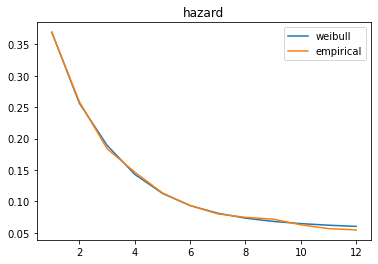

In [31]:
pred_haz = [None]*13
for t in range(1, 13):
    pred_haz[t] = churn[t]/pred_alive[t-1]

emp_haz = [None]*13
for t in range(1, 13):
    emp_haz[t] = data_in.lost[t]/data_in.Customers[t-1]

plt.plot(pred_haz, label='weibull')
plt.plot(emp_haz, label='empirical')
plt.title('hazard')
plt.legend()
plt.show()

In [32]:
num_params = 5
BIC = num_params * np.log(pop_size) - 2 * (-mle_model.fun) 
BIC

3393.75483538003

This is worse than the 2-segment exponential model.

#### Infinite Segments - Weibull Gamma Model

In [38]:
# we take the first 8 rows
data = data_in.copy()
data = data[0:8]

def MLE_Weib_Gamma(params):

    alpha = params[0]
    r = params[1]
    c = params[2]

    # Find the probability of churning.
    F_t = 1 - (alpha/(alpha + data.Year**c))**r
    F_t_minus_1 = 1 - (alpha/(alpha + (data.Year - 1)**c))**r
    Prob = F_t - F_t_minus_1

    # Now find the probability of not churning. It is one minus the sum of all
    # the prior probabilities of churning.
    Prob_not_churn = 1 - np.sum(Prob[1:])

    # Find the sum of log-likelihoods. Be sure to weight by the number of customers
    # churning at each time point. Remember that time t=0 doesn't have a realistic
    # value and should be ignored.
    LL = np.sum(np.log(Prob[1:]) * data_in.lost[1:])

    # Add in the log-likelihood for the people who hadn't churned by year 7.
    LL += np.log(Prob_not_churn) * data_in.Customers[7]

    return -LL

$\alpha$, $r$, and $c$ must be greater than 0 but are otherwise unbounded.

In [39]:
bounds = [(0, 100), (0, 100), (0, 100)]
x0 = [1, 1, 1]
mle_model = minimize(MLE_Weib_Gamma, x0 = x0, method='Nelder-mead', bounds=bounds, options={'disp': True})
mle_model

Optimization terminated successfully.
         Current function value: 1679.603558
         Iterations: 110
         Function evaluations: 199


 final_simplex: (array([[0.54409802, 0.44134042, 1.32432582],
       [0.54418742, 0.44138093, 1.32425786],
       [0.54414296, 0.44136274, 1.32427637],
       [0.54412404, 0.44135738, 1.32430716]]), array([1679.60355827, 1679.60355828, 1679.60355828, 1679.60355832]))
           fun: 1679.603558274835
       message: 'Optimization terminated successfully.'
          nfev: 199
           nit: 110
        status: 0
       success: True
             x: array([0.54409802, 0.44134042, 1.32432582])

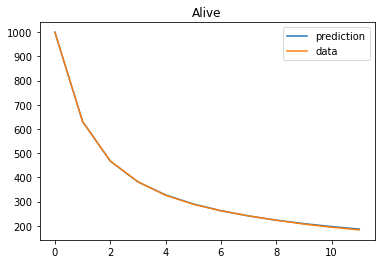

In [40]:
# Note that we use data_in because we want to study all 12 years.
pop_size = data_in.Customers[0] # 1000 customers

alpha = mle_model.x[0]
r = mle_model.x[1]
c = mle_model.x[2]

# Find the probability of churning.
F_t = 1 - (alpha/(alpha + data_in.Year**c))**r
F_t_minus_1 = 1 - (alpha/(alpha + (data_in.Year - 1)**c))**r
Prob = F_t - F_t_minus_1

churn = Prob * pop_size

pred_alive = [None] * 12
pred_alive[0] = pop_size
for i in range(1, 12):
    pred_alive[i] = pred_alive[i-1] - churn[i]

plt.plot(pred_alive, label='prediction')
plt.plot(data_in.Customers[0:12], label='data')
plt.legend()
plt.title('Alive')
plt.show()

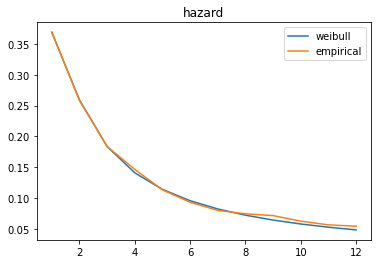

In [41]:
pred_haz = [None]*13
for t in range(1, 13):
    pred_haz[t] = churn[t]/pred_alive[t-1]

emp_haz = [None]*13
for t in range(1, 13):
    emp_haz[t] = data_in.lost[t]/data_in.Customers[t-1]

plt.plot(pred_haz, label='weibull')
plt.plot(emp_haz, label='empirical')
plt.title('hazard')
plt.legend()
plt.show()

In [42]:
num_params = 3
BIC = num_params * np.log(pop_size) - 2 * (-mle_model.fun) 
BIC

3379.930382386616

This is worse than the exponential gamma model.